---
title: Finite Difference
suptitle: Loops, Slicing, and Stencils
short_title: Finite Difference
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

**Jax Methods**

* Loops
* Scanning
* Convolutions
* Stencils

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

```{math}
:label: pde
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0
```

For the PDE {eq}`pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

```{math}
:label: discretization_full
u_{i,j}^{n+1} = u_{i,j}^{n} - c \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
```

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [3]:
# defime some variables
tmax = 10.0
nt = 1_000
a = 1
dt = tmax / nt
t0 = tmax / 2
time = np.linspace(0, tmax, nt)


def fn(time, t0, a):
    return (1 / np.sqrt(2 * np.pi * a)) * np.exp(- (((time - t0)**2) / (2 * a)))

def dfn(time, t0, a):
    return (-(time - t0)/a) * (1/np.sqrt(2*np.pi*a))*np.exp(-(time-t0)**2/(2*a))


In [4]:
solutions = dict()
f = fn(time, t0, a)
df = dfn(time, t0, a)
solutions["function"] = f
solutions["analytical"] = df

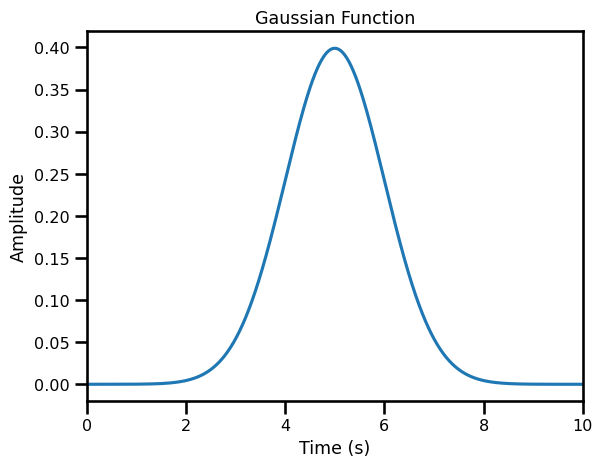

In [5]:
fig, ax = plt.subplots()
ax.plot(time, f)
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.show()

## Derivative Operators

Let's take some simple 1st order, first derivative formulations.

$$
\begin{aligned}
\mathcal{N}_\text{Forward}[u](x) &=  \frac{1}{\Delta x}(u_{i+1} + u_{i}) \\
\mathcal{N}_\text{Central}[u](x) &= \frac{1}{\Delta x}(\frac{1}{2}u_{i+1} - u_i - \frac{1}{2}u_{i-1}) \\
\mathcal{N}_\text{Backward}[u](x) &= \frac{1}{\Delta x}(u_i - u_{i-1}) \\
\end{aligned}
$$ (fd_schemes)



In [8]:
import jaxsw._src.operators.functional.fd as fd
import jaxsw._src.operators.functional.padding as fd_pad
import jaxsw._src.operators.functional.conv as fd_conv

## Convolutions

Let's take a field, $u$, which is defined as: 

$$
u := u(t) \hspace{10mm} u: \mathcal{T}\rightarrow \mathbb{R}\hspace{5mm} t\in\mathcal{T}\sub\mathbb{R}^+
$$

take a stencil, $k$, which is defined as:

$$
k := k(\Delta t) \hspace{10mm} k: \Delta t \in\mathcal{T}_k
$$

So we can define a convolution as the following.

$$
u(t) = \sum_{\Delta t \in \mathcal{T}_k}u(t+\Delta t) \cdot k(\Delta t)
$$

Essentially we are saying, take all of the values that are within the subdomain of the kernel, and sum them to get a scalar value.





We can write this more compactly as:

$$
\partial_t \mathbf{u} = \mathbf{u} * \mathbf{k} 
$$

:::{note} 
:class: dropdown
**Generalized Convolutions**

We can also have them in 1 dimensions in space

$$
u(x) = \sum_{\Delta x \in \Omega_k}u(x+\Delta x) \cdot k(\Delta x)
$$


2 dimensions in space

$$
u(x,y) = \sum_{(\Delta x, \Delta y) \in \Omega_k}u(x+\Delta x, y+\Delta y) \cdot k(\Delta x, \Delta y)
$$

:::





:::{note} 
:class: dropdown
**Convolutions**

It's often good to get a good intuition behind convolutions to really understand what's really going on. 

* I like this video by [3Blue3Brown](https://www.youtube.com/watch?v=KuXjwB4LzSA) which goes through the intuition.
* All videos in this [channel](https://www.youtube.com/@animatedai/videos) are excellent explaining convolutions.
* A great lecture by Chris talks about the equivalency between finite difference schemes and convolutional neural networks - [Partial Differential Equations (PDEs), Convolutions, and the Mathematics of Locality](https://www.youtube.com/watch?v=apkyk8n0vBo)


:::

In [47]:
step_size = dt
axis = 0
accuracy = 2
derivative = 1
mode = "edge"
method = "central"

# generate offsets
offsets = fd.generate_central_offsets(derivative=derivative, accuracy=accuracy)
coeffs = fd.generate_finitediff_coeffs(offsets=offsets, derivative=derivative)
padding = fd_pad.generate_central_padding(derivative=derivative, accuracy=accuracy)

In [48]:
# initialize kernel
kernel = fd_conv.fd_kernel_init(dx=(dt,), coeffs=coeffs, axis=axis)

# convolution
df_conv = fd_conv.fd_convolution(f, kernel=kernel, pad=padding, mode=mode)

In [49]:
x.shape, x_.shape

((1000,), (1000,))

## Comparisons


#### Methods

| Operation | Spatial Domain | Frequency Domain |
|:---------:|:--------------:|:----------------:|
| Linearity | $c_1f_1(x) + c_2 f_2(x)$ | $c_1 F_1(\omega) + c_2 F_2(\omega)$ |
| Scaling | $f(ax)$ | $\frac{1}{\| a \|} F(\frac{\omega}{a})$ |
| Shifting | $f(x - x_0)$ | $\exp\left(-i2\pi\omega x_0\right)F(\omega)$ |
| Differentiation | $\frac{d^n f(x)}{dx^n}$ | $(i2\pi\omega)^nF(\omega)$ |
| Convolutions | $f(x)*g(x)$ | $F(\omega)G(\omega)$ |

#### Computational Complexity

A standard convolution has $\mathcal{O}(N^2)$ complexity. An FFT-based convolution has $\mathcal{O}(N\log N)$ complexity.



#### Convolution Theorem

$$
\mathcal{F}\left\{ f(x) * g(x)\right\}(\omega) = F(\omega)G(\omega)
$$

$$
\mathcal{F}\left\{ f * g\right\}(\omega)
$$

**Spatial Domain**

$$
f * g = h
$$

$$
\left(\mathcal{F}\circ f\right) \left(\mathcal{F}\circ g\right) = \mathcal{F}\circ h
$$

$$
\left(\mathcal{F}^{-1}\circ\mathcal{F}\circ f\right)\left(\mathcal{F}^{-1}\circ\mathcal{F}\circ g\right) = \left(\mathcal{F}^{-1}\circ\mathcal{F}\circ f\right)
$$

### Properties of Convolutions

We have quite a few properties of convolutions that we can access.

[Source](https://tomfletcher.github.io/FoDA/lectures/L19-Convolution.pdf)

**Commutativity** 

$$
u * k = u * k
$$

> This means we can think of the image as the kernel and the kernel as the image and get the same result. So we could leave the image fixed and slide the kernel or leave the kernel fixed and slide the image



**Associativity**

$$
(u * k_1) * k_2 = u * (k_1 * k_2)
$$

> This means we can apply a kernel, $k_1$, to a field, $u$, followed by another kernel, $k_2$, or we can convolve the kernels $k_1 * k_2$ and then apply the resulting kernel to the field, $u$.


**Linearity**

$$
\begin{aligned}
(a \cdot u) * k_1 &= a \cdot (u * k) \\
(u_1 + u_2) * k &= (u_1 * k) + (u_2 * k)  
\end{aligned}
$$

> We can multiply a field by a constant before or after the convolution. We can also add two fields before or after the convolution and get the same results.


**Shift-Invariance**

Let $S$ be the operator that shifts the elements of the field, $u$:

$$
S(u)(x,y) = u(x + \delta x, y + \delta u) 
$$

Then

$$
S(u * k) = S(u) * k
$$

> We can convolve the field $u$ and the kernel $k$ and then shift the result, or we can shift $u$ and convolve it with $k$.

### Computational Complexity

If my field, $u$, has the size $D_x\times D_y$ and my kernel $K$ has the size $(2R+1)\times(2R+1)$, we can write this as:

$$
u(x,u) = \sum_{\Delta t = -R}^R\sum_{\Delta y = -R}^R u(x-\Delta x, y - \Delta y) \cdot k(\Delta x, \Delta y)
$$

Then the computational complexity is

$$
\mathcal{O}\left(D_x D_y(2R+1)(2R+1) \right) = \mathcal{O}\left( D_x D_y R^2\right)
$$

If the domain is fixed then it is $\mathcal{O}(R^2)$.

**Note**: applying convolutions on GPUs is very efficient by today's standards. [Wei et. al., 2022](https://doi.org/10.1016/j.aiopen.2022.10.002). We also have various convolutions available (see [video](https://www.youtube.com/watch?v=SiJpkucGa1o).


**Example**: Let's take a simple example of *which is more expensive*. Let's say we want to shift an image by 10 pixels to the left.

1. We convolve a $21\times 21$ shift operator with a 1 on the right edge.
2. We convolve repeatedly a $3\times 3$ shift operator 10 times.

Method 1 requires us to do $21^2\cdot D_x D_y = 441 \cdot D_x D_y$. However, method 2 requires $(9 \cdot D_x D_y) \cdot 10 = 90 \cdot D_x D_y$

### Finite Difference Methods


#### Forward Difference

$$
\partial_+ f(x) \approx f(x + 1) - f(x)
$$

We can take a convolutional kernel: 

$$
k = \begin{bmatrix}1 & -1 & 0\end{bmatrix}
$$

which gives us

$$
\partial_+ f(x) \approx f(x) * k
$$

**Note 1**: A kernel is flipped in convolution!

**Note 2**: Derivative kernels sum to zero!


#### Central Difference

$$
\partial_+ f(x) \approx \frac{1}{2} \left(f(x + 1) - f(x-1)\right)
$$

We can take a convolutional kernel: 

$$
k = \begin{bmatrix}0.5 & 0 & -0.5\end{bmatrix}
$$

which gives us

$$
\partial f(x) \approx f(x) * k
$$




## Boundaries

* Crop
* Pad
* Extend
* Wrap - Fourier Methods

In [50]:
step_size = dt
axis = 0
accuracy = 8
derivative = 1
mode = "edge"
method = "central"

# generate offsets
offsets = fd.generate_central_offsets(derivative=derivative, accuracy=accuracy)
coeffs = fd.generate_finitediff_coeffs(offsets=offsets, derivative=derivative)
padding = fd_pad.generate_central_padding(derivative=derivative, accuracy=accuracy)

# finite difference from slicing
df_slicing = fd.finite_difference(
    f, derivative=derivative,
    step_size=step_size, axis=axis, 
    coeffs=coeffs, offsets=offsets,
    padding=padding, 
    mode=mode
)

# initialize kernel
kernel = fd_conv.fd_kernel_init(dx=(dt,), coeffs=coeffs, axis=axis)

# convolution
df_conv = fd_conv.fd_convolution(f, kernel=kernel, pad=padding, mode=mode)

np.testing.assert_array_almost_equal(df_slicing, df_conv, decimal=5)

In [51]:
import functools as ft
a = 1
nt_test = 100_000
dt_test = tmax / nt_test
t0_test = tmax / 2
time_test = np.linspace(0, tmax, nt_test)
f_test = fn(time_test, t0_test, a)

f_test = jnp.asarray(f_test)

fn_slice = ft.partial(fd.finite_difference, 
                      derivative=derivative,
                      step_size=step_size, axis=axis, 
                      coeffs=coeffs, offsets=offsets,
                      padding=padding, 
                      mode=mode
                     )
fn_slice = jax.jit(fn_slice)

%timeit fn_slice(f_test).block_until_ready()

fn_conv = ft.partial(fd_conv.fd_convolution, 
                      kernel=kernel, pad=padding, mode=mode
                     )
fn_conv = jax.jit(fn_conv)

%timeit fn_conv(f_test).block_until_ready()

105 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
1.13 ms ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [219]:
import kernex as kex

    
@kex.kmap(kernel_size=(3,), padding="same", relative=True)
def fd_central_kernel(u, dx):
    return (u[1] - u[-1]) / (2 * dx)
    

def fd_central_loop(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    un = jnp.zeros_like(u)
    for i in range(1, u.shape[0]-1):
        un = un.at[i].set((u[i+1] - u[i-1])/(2*dx))
    return un

def fd_central_slice(u: Float[Array, "Nx"], dx: float) -> Float[Array, "Nx"]:
    # pad array
    u = jnp.pad(u, pad_width=((1,1)), mode="constant")
    return (u[2:] - u[:-2]) / ( 2 * dx )

In [230]:
%timeit fd_central_kernel(f, dt).block_until_ready()
%timeit fd_central_loop(f, dt).block_until_ready()
%timeit fd_central_slice(f, dt).block_until_ready()
%timeit sk.fd.difference(f, axis=0, accuracy=2, step_size=dt).block_until_ready()

2.81 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
363 ms ± 19.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
286 µs ± 1.57 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
6.98 µs ± 24.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [231]:
from functools import partial
fn = jax.jit(fd_central_kernel, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_loop, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = jax.jit(fd_central_slice, static_argnums=(1,))
%timeit fn(f, dt).block_until_ready()
fn = partial(sk.fd.difference, axis=0, accuracy=2, step_size=dt)
fn = jax.jit(fn, static_argnums=(1,2,3,))
%timeit fn(f).block_until_ready()

4.07 µs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.67 µs ± 28.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
3.66 µs ± 64.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
8.98 µs ± 4.32 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
derivatives = dict()

derivatives["kernel"] = fd_central_kernel(f, dt)
derivatives["loop"] = fd_central_loop(f, dt)
derivatives["slice"] = fd_central_slice(f, dt)
derivatives["serket"] = sk.fd.difference(f, axis=0, accuracy=2, step_size=dt)

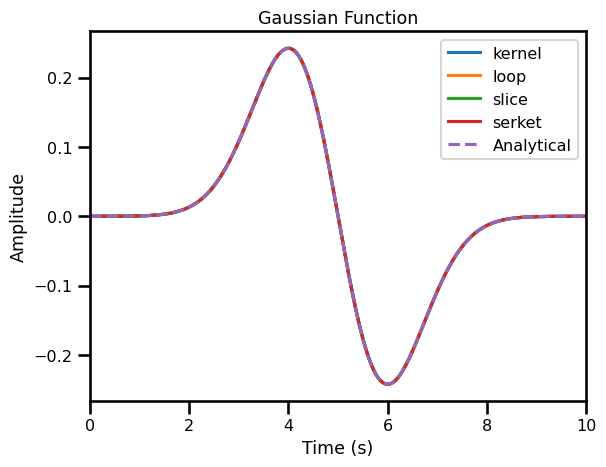

In [211]:
fig, ax = plt.subplots()
ax.plot(time, derivatives["kernel"], label="kernel")
ax.plot(time, derivatives["loop"], label="loop")
ax.plot(time, derivatives["slice"], label="slice")
ax.plot(time, derivatives["serket"], label="serket")
ax.plot(time, df, label="Analytical", linestyle="--")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()

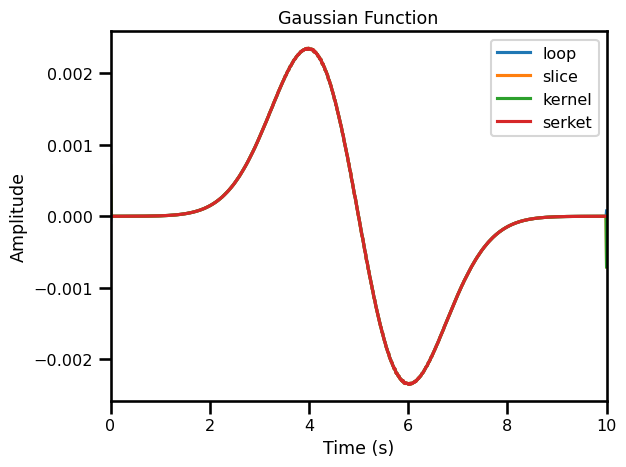

In [214]:
fig, ax = plt.subplots()
ax.plot(time, 
        10*(derivatives["loop"] - df), label="loop")
ax.plot(time, 
        10*(derivatives["slice"] - df), label="slice")
ax.plot(time, 
        10*(derivatives["kernel"] - df), label="kernel")
ax.plot(time, 
        10*(derivatives["serket"] - df), label="serket")
ax.set(
    title="Gaussian Function",
    xlabel="Time (s)",
    ylabel="Amplitude",
    xlim=(0,tmax)
)
plt.legend()
plt.show()